# Part I : Create Your Own Dataset and Train it with ConvNets

In this part of the notebook, you will set up your own dataset for image classification. Please specify 
under `queries` the image categories you are interested in. Under `limit` specify the number of images 
you want to download for each image category. 

You do not need to understand the class `simple_image_download`, just execute the cell after you have specified 
the download folder.


In [2]:
!conda env list

# conda environments:
#
base                     /Users/Bernardo/opt/anaconda3
adam                     /Users/Bernardo/opt/anaconda3/envs/adam
dwl01                    /Users/Bernardo/opt/anaconda3/envs/dwl01
nlp                      /Users/Bernardo/opt/anaconda3/envs/nlp
rEnv                     /Users/Bernardo/opt/anaconda3/envs/rEnv
vision                *  /Users/Bernardo/opt/anaconda3/envs/vision
watson                   /Users/Bernardo/opt/anaconda3/envs/watson



In [3]:
!pip install selenium

  Using cached selenium-4.1.0-py3-none-any.whl (958 kB)
  Using cached trio-0.19.0-py3-none-any.whl (356 kB)
  Using cached trio_websocket-0.9.2-py3-none-any.whl (16 kB)
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached outcome-1.1.0-py2.py3-none-any.whl (9.7 kB)
  Using cached wsproto-1.0.0-py3-none-any.whl (24 kB)
     |████████████████████████████████| 2.6 MB 4.9 MB/s            
  Using cached pyOpenSSL-21.0.0-py2.py3-none-any.whl (55 kB)
  Using cached h11-0.12.0-py3-none-any.whl (54 kB)


In [4]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
#from Image_crawling import Image_crawling
from notebooks_Block_5_Image_crawling import Image_crawling
from get_gecko_driver import GetGeckoDriver

# Adds the downloaded GeckoDriver to (actual) path
get_driver = GetGeckoDriver()
get_driver.install()

# Specifiy the queries
#queries = ["brad pitt","johnny depp", "leonardo dicaprio", "robert de niro", "angelina jolie", "sandra bullock", "catherine deneuve", "marion cotillard"]
queries = [
    "brad pitt",
    "johnny depp", 
    "leonardo dicaprio", 
    "robert de niro", 
    "angelina jolie", 
    "sandra bullock", 
    "catherine deneuve", 
    "marion cotillard"
    ]

limit = 2
download_folder = "./brandnew_images/train/"
waittime = 0.1  # Time to wait between actions, depends on the number of pictures you want to crawl. More pictures means you need to wait longer for them to load. 

# Set options
options = webdriver.FirefoxOptions()
options.add_argument('--headless')

# Create Driver
driver = webdriver.Firefox(options=options)#, executable_path="./geckodriver")

# create instance of crawler
image_crawling = Image_crawling(driver, waittime=waittime)

# Find urls and download images
for query in queries:
    # Craws image urls:
    image_urls = image_crawling.fetch_image_urls(query, limit)
      
    # download images
    image_crawling.download_image(download_folder + query)


ModuleNotFoundError: No module named 'notebooks_Block_5_Image_crawling'

Please check carefully the downloaded images, there may be a lot of garbage! You definitely need to 
clean the data.

In the following, you will apply data augmentation to your data set.

In [2]:
# General imports
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)
import numpy as np
import matplotlib.pyplot as plt

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# the ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

Found 420 images belonging to 8 classes.


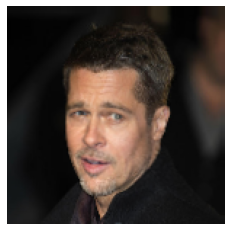

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [4]:
# These are the class names; this defines the ordering of the classes
class_names = ["brad pitt", "johnny depp", "leonardo dicaprio", "robert de niro",
           "angelina jolie", "sandra bullock", "catherine deneuve", "marion cotillard"]


# Class ImageDataGenerator() returns an iterator holding one batch of images
# the constructor takes arguments defining the different image transformations
# for augmentation purposes (rotation, x-/y-shift, intensity scaling - here 1./255 
# to scale range to [0, 1], shear, zoom, flip, ... )
train_datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


dir_iter = train_datagen.flow_from_directory('celebrity-faces-train-validation-dataset/train',#'./brandnew_images/train/', 
                                         target_size=(image_size, image_size),
                                         classes=class_names,
                                         batch_size=25, class_mode='sparse', shuffle=False)

plot_img(dir_iter[0][0][1,...])
dir_iter[0][1]

Before you continue, you need to split the downloaded images into a `train` folder and into a `validation` folder.

If you want to use the example of this jupyter notebook, you can use the images provided in the ./train and ./validation folders.

## Define a ConvNet Model

In [5]:
batch_size = 20
num_train_images = 480
num_valid_images = 80
num_classes = 8

model_scratch = Sequential()
model_scratch.add(Conv2D(32, (3, 3), input_shape=(image_size, image_size, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(32, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(Conv2D(64, (3, 3)))
model_scratch.add(Activation('relu'))
model_scratch.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_scratch.add(Flatten())  
model_scratch.add(Dense(64))
model_scratch.add(Activation('relu'))
model_scratch.add(Dropout(0.5))
model_scratch.add(Dense(num_classes))
model_scratch.add(Activation('softmax'))

model_scratch.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



2021-10-21 14:17:27.159706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# This is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# This is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# This is a generator that will read pictures found in
# subfolers of './train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'celebrity-faces-train-validation-dataset/train',  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=class_names,
        batch_size=batch_size)  

# This is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        'celebrity-faces-train-validation-dataset/validation',
        target_size = (image_size, image_size),
        classes = class_names,
        batch_size = batch_size)

Found 0 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


In [22]:
name = 'cnn_face_1'

tensorboard = TensorBoard(
        log_dir ='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

2021-10-21 13:51:19.944619: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-21 13:51:19.944642: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-21 13:51:19.945805: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [ ]:
history = model_scratch.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = [tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/20
 2/24 [=>............................] - ETA: 16s - loss: 2.4319 - accuracy: 0.1000

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - 10s 398ms/step - loss: 2.1400 - accuracy: 0.1125 - val_loss: 2.0787 - val_accuracy: 0.2000
Epoch 2/20
24/24 [==============================] - 9s 363ms/step - loss: 2.0715 - accuracy: 0.1688 - val_loss: 2.0529 - val_accuracy: 0.2250
Epoch 3/20
24/24 [==============================] - 8s 347ms/step - loss: 2.0450 - accuracy: 0.1708 - val_loss: 2.0063 - val_accuracy: 0.2250
Epoch 4/20
24/24 [==============================] - 8s 353ms/step - loss: 1.9824 - accuracy: 0.2104 - val_loss: 1.9108 - val_accuracy: 0.2250
Epoch 5/20
24/24 [==============================] - 8s 342ms/step - loss: 1.9082 - accuracy: 0.2438 - val_loss: 1.8576 - val_accuracy: 0.3250
Epoch 6/20
24/24 [==============================] - 8s 347ms/step - loss: 1.8140 - accuracy: 0.3167 - val_loss: 1.7524 - val_accuracy: 0.3875
Epoch 7/20
24/24 [==============================] - 8s 346ms/step - loss: 1.7485 - accuracy: 0.3271 - val_loss: 1.6948 - val_accuracy: 0.3875
Epoch 8/20
24/24

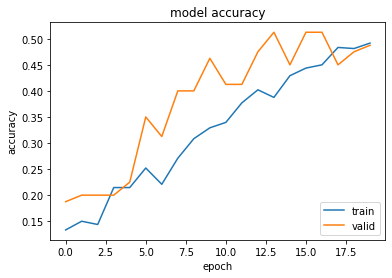

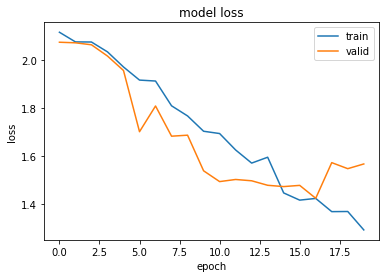

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Tensorboard

In [ ]:
%load_ext tensorboard
import datetime, os

tensorboard --logdir="./tensorboard/log" --port=8006

SyntaxError: can't assign to operator (<ipython-input-23-a8183cac7339>, line 4)

In [17]:
!tensorboard --port=8006 --logdir=tensorboard/

2021-01-13 13:04:44.327338: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2021-01-13 13:04:44.327578: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2021-01-13 13:04:44.327606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0113 13:04:46.114789 140433571792640 plugin_event_accumulator.py:300] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0113 13:04:46.125888 140433571792640

# Part II : Transfer Learning

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

We will continue using VGG16 model, which comes among others prepackaged with Keras. You can import it from the `tensorflow.keras.applications` module. Here's the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of `tensorflow.keras.applications`:

- Xception
- Inception V3 
- ResNet50
- VGG16
- VGG19
- MobileNet




TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. Any [image feature vector URL from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) would work here.

Note that we're calling the partial model (without the final classification layer) a `feature_extractor`. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

Let's instantiate the VGG16 model.

In [23]:
# General imports
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# Shortcuts to keras if (however from tensorflow)
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard 

# Shortcut for displaying images
def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
# The target image size can be fixed here (quadratic)
# The ImageDataGenerator() automatically scales the images accordingly (aspect ratio is changed)
image_size = 150

In [24]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))


58892288/58889256 [==============================] - 6s 0us/step


You pass three arguments to the constructor:

- `weights` specifies the weight checkpoint from which to initialize the model.

- `include_top` refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1000 classes from 
ImageNet. Because we intend to use our own densely connected classifier  you don't need to include it.

- `input_shape` is the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, the network will be able to process inputs of any size.

In [25]:
# predict_generator requires compilation
vgg16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Here's the detail of the architecture of teh VGG16 convolutional base. It's similar to the simple ConvNets you are familiar with:

In [26]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

The final feature map (output volume) has shape $(4, 4, 512)$. That's the feature on top of which we will stick a densely connected classifier.

At this point, there are two ways how we could proceed:

- __Approach 1__: Running the convolutional base over our dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier similar to those we saw earlier in this course. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive pipeline. But for the same reason, this technique won't allow us to use data augmentation.

- __Approach 2__: Extending the model we have (`vgg16`) by adding `Dense` on top, and running the whole thing end to end on the input data. This will allow us to use data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But for the same reason, this technique is far more expensive than the first.

## 1. Approach : Extracting Features Using the Pretrained Convolutional Base

### Fast Feature Extraction without Data Augmentation

We will start by running instances of the previously introduced `ImageDataGenerator` to extract images as Numpy arrays as well as their labels. We will extract features from these images by calling the `predict` method of the `vgg16`model.

Let's run the training images through the convolutional base, and see the final shape. 480 is the number of images, and 512 is the number of activation maps in the last layer of the partial model from VGG16.

In [31]:
# These are the class names; this defines the ordering of the classes
class_names = ["brad pitt", "johnny deep", "leonardo dicaprio", "robert de niro",
               "angelina jolie", "sandra bullock", "catherine deneuve", "marion cotillard"]

# No augmentation 
datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20
num_train_images = 480
num_valid_images = 80
num_classes = 8

generator = datagen.flow_from_directory(
        './train',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        # this means our generator will only yield batches of 
        # data, no labels
        class_mode=None,  
        # our data will be in order
        shuffle=False)  

# the predict_generator method returns the CNN activation maps 
# of the last layer
bottleneck_features_train = vgg16.predict_generator(generator, 
                                                    num_train_images // batch_size)

print("Shape of last layer feature map of training dataset:", bottleneck_features_train.shape)

# save the output as a Numpy array
np.save('./models/bottleneck_features_train.npy', bottleneck_features_train)

generator = datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        classes=class_names,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = vgg16.predict_generator(generator, 
                                                         num_valid_images // batch_size)

np.save('./models/bottleneck_features_validation.npy', bottleneck_features_validation)

print("Shape of last layer feature map of validation dataset:", bottleneck_features_validation.shape)

Found 480 images belonging to 8 classes.
Shape of last layer feature map of training dataset: (480, 4, 4, 512)
Found 80 images belonging to 8 classes.
Shape of last layer feature map of validation dataset: (80, 4, 4, 512)


##### Load numpy array containing activation maps of training dataset

In [32]:
train_data = np.load('./models/bottleneck_features_train.npy')

# the features were saved in order, so recreating the labels is easy
train_labels = np.zeros((num_train_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_train_images // num_classes
    train_labels[ind*step:(ind+1)*step,ind]=1

train_labels

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

##### Load numpy array containing activation maps of validation dataset

In [33]:
validation_data = np.load('./models/bottleneck_features_validation.npy')
validation_labels = np.zeros((num_valid_images, num_classes), dtype=int)
for ind in range(num_classes):
    step = num_valid_images // num_classes
    validation_labels[ind*step:(ind+1)*step,ind]=1

#### Defining a Densely Connected Classification Head 

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [34]:
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

top_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
name = 'vgg16_bottleneck_face'

tensorboard_1 = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [36]:
history = top_model.fit(train_data, train_labels,
          epochs=10,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels),
          callbacks=[tensorboard_1])

top_model.save_weights('./models/bottleneck_fc_model.h5')

Train on 480 samples, validate on 80 samples
Epoch 1/10
480/480 [==============================] - 1s 1ms/sample - loss: 2.1564 - accuracy: 0.2688 - val_loss: 1.4031 - val_accuracy: 0.5000
Epoch 2/10
480/480 [==============================] - 0s 299us/sample - loss: 1.2878 - accuracy: 0.5167 - val_loss: 1.1762 - val_accuracy: 0.5625
Epoch 3/10
480/480 [==============================] - 0s 299us/sample - loss: 0.8945 - accuracy: 0.6667 - val_loss: 0.9894 - val_accuracy: 0.6500
Epoch 4/10
480/480 [==============================] - 0s 310us/sample - loss: 0.7726 - accuracy: 0.7333 - val_loss: 0.9006 - val_accuracy: 0.7000
Epoch 5/10
480/480 [==============================] - 0s 338us/sample - loss: 0.5742 - accuracy: 0.8104 - val_loss: 0.8266 - val_accuracy: 0.7375
Epoch 6/10
480/480 [==============================] - 0s 329us/sample - loss: 0.4625 - accuracy: 0.8542 - val_loss: 0.7848 - val_accuracy: 0.7375
Epoch 7/10
480/480 [==============================] - 0s 321us/sample - loss: 0.3

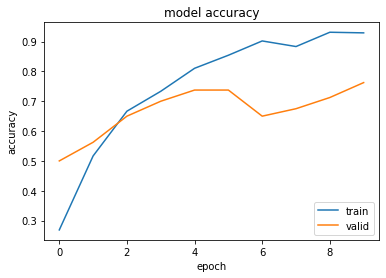

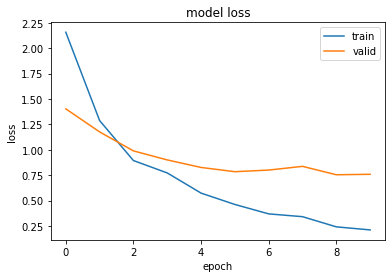

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## 2. Approach : Training the model end to end with a frozen convolutional base

Now let us apply the second technique which we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to use data augmentation during training: extending the `vgg16` model and running it end to end on the inputs. 

Because models behave just like layers, we can add a model (like `vgg16`) to a `Sequential` model just we would add a layer.

#### Adding a densely connected classifier on top of the convolutional base

In [38]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import applications

vgg16 = applications.VGG16(include_top=False, weights='imagenet',
                           input_shape=(image_size,image_size,3))

model_freeze_conv = models.Sequential()
model_freeze_conv.add(vgg16)
model_freeze_conv.add(layers.Flatten())
model_freeze_conv.add(layers.Dense(256, activation = 'relu'))
model_freeze_conv.add(layers.Dense(num_classes, activation = 'softmax'))

This is what the model looks like now:

In [39]:
model_freeze_conv.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 16,814,152
Non-trainable params: 0
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14'714'688 parameters, which is very large. The classifier we are adding on top has 
2 million parameters.

Before we compile a layer and train the model, it is very important to __freeze__  the convolutional base. _Freezing_ a layer or a set of layers means preventing their weights from being updated during training. If you don't do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the `Dense` layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze  a network by setting its `trainable` attribute to `False`: 

In [40]:
print('This is the number of trainable weights '
     'before freezing the conv base:', len(model_freeze_conv.trainable_weights))

vgg16.trainable = False

print('This is the number of trainable weights '
     'after freezing the conv base:', len(model_freeze_conv.trainable_weights))


This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If we ever modify weight trainability after compilation, we should then recompile the model, or these changes will be ignored.

Now, we can start training our model, with the same data-augmentation configuration that we used in the previous example.

In [41]:
image_size = 150
batch_size = 20
num_train_images = 480
num_valid_images = 80
num_classes = 8

class_names = ["brad pitt", "johnny deep", "leonardo dicaprio", "robert de niro",
           "angelina jolie", "sandra bullock", "catherine deneuve", "marion cotillard"]


# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

model_freeze_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_freeze_conv.summary()

Found 480 images belonging to 8 classes.
Found 80 images belonging to 8 classes.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 2,099,464
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
name = 'cnn_face_2'

tensorboard_2 = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [43]:
epochs = 15

history=model_freeze_conv.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_2])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/15
 9/24 [==========>...................] - ETA: 10s - loss: 2.7824 - accuracy: 0.2000

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - 16s 683ms/step - loss: 2.1956 - accuracy: 0.3187 - val_loss: 1.4464 - val_accuracy: 0.4125
Epoch 2/15
24/24 [==============================] - 14s 579ms/step - loss: 1.0362 - accuracy: 0.6292 - val_loss: 1.1068 - val_accuracy: 0.6000
Epoch 3/15
24/24 [==============================] - 15s 631ms/step - loss: 0.7250 - accuracy: 0.7688 - val_loss: 0.9805 - val_accuracy: 0.6875
Epoch 4/15
24/24 [==============================] - 14s 582ms/step - loss: 0.5073 - accuracy: 0.8542 - val_loss: 0.9652 - val_accuracy: 0.6125
Epoch 5/15
24/24 [==============================] - 15s 634ms/step - loss: 0.3990 - accuracy: 0.8896 - val_loss: 0.9173 - val_accuracy: 0.6500
Epoch 6/15
24/24 [==============================] - 15s 641ms/step - loss: 0.3288 - accuracy: 0.9083 - val_loss: 0.8168 - val_accuracy: 0.6625
Epoch 7/15
24/24 [==============================] - 15s 640ms/step - loss: 0.2804 - accuracy: 0.9396 - val_loss: 0.7954 - val_accuracy: 0.6875
Epoch 8/15

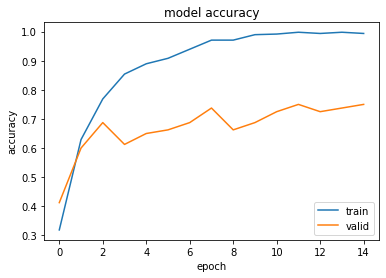

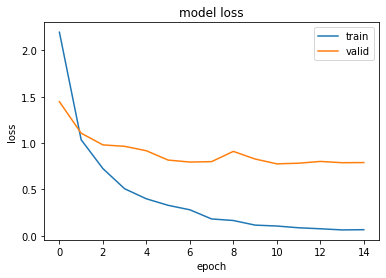

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## Fine Tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 

Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called _fine-tuning_ because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant at hand.

The steps for fine-tuning are as follows:

1. Add your custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added.

We already completed the first three steps in the previous example. As a remainder, this is what our convolutional base looks like:

In [45]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We will fine-tune the last three convolutional layers, which means all layers up to `block4_pool` should be frozen, and the layers `block5_conv1`, `block5_conv2`, and `block5_conv3` should be trainable.

In [51]:
vgg16.trainable = True

set_trainable = False

for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers[0:]:
    print('layer name = ' + layer.name + ', shape = ' + repr(layer.output_shape)
            + ', trainable = ' + repr(layer.trainable))        
    

layer name = input_2, shape = [(None, 150, 150, 3)], trainable = False
layer name = block1_conv1, shape = (None, 150, 150, 64), trainable = False
layer name = block1_conv2, shape = (None, 150, 150, 64), trainable = False
layer name = block1_pool, shape = (None, 75, 75, 64), trainable = False
layer name = block2_conv1, shape = (None, 75, 75, 128), trainable = False
layer name = block2_conv2, shape = (None, 75, 75, 128), trainable = False
layer name = block2_pool, shape = (None, 37, 37, 128), trainable = False
layer name = block3_conv1, shape = (None, 37, 37, 256), trainable = False
layer name = block3_conv2, shape = (None, 37, 37, 256), trainable = False
layer name = block3_conv3, shape = (None, 37, 37, 256), trainable = False
layer name = block3_pool, shape = (None, 18, 18, 256), trainable = False
layer name = block4_conv1, shape = (None, 18, 18, 512), trainable = False
layer name = block4_conv2, shape = (None, 18, 18, 512), trainable = False
layer name = block4_conv3, shape = (None, 1

Now we can begin fine-tuning the network. First we join the top_model layer on top of the vgg16 model with some top layers unfrozen:

In [47]:
model_fine_tuned = models.Sequential()
model_fine_tuned.add(vgg16)
from tensorflow.keras import optimizers

for layer in top_model.layers[0:]:
    layer.trainable = True
    model_fine_tuned.add(layer)  


model_fine_tuned.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])  

model_fine_tuned.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 16,814,152
Trainable params: 9,178,888
Non-trainable params: 7,635,264
_________________________________________________________________


In [48]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

validation_generator = validation_datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        classes=class_names,
        batch_size=batch_size)

Found 480 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


In [49]:
name = 'vgg16_face_fine_tuned'

tensorboard_3 = TensorBoard(
        log_dir='./tensorboard/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [50]:
# fine-tune the model
epochs = 10

history=model_fine_tuned.fit_generator(
        train_generator,
        steps_per_epoch=num_train_images // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=num_valid_images // batch_size,
        callbacks=[tensorboard_3])

model_fine_tuned.save_weights('./models/model_fined_tuned.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 4 steps
Epoch 1/10
 7/24 [=======>......................] - ETA: 16s - loss: 0.5607 - accuracy: 0.8000

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


24/24 [==============================] - 23s 974ms/step - loss: 0.5908 - accuracy: 0.8125 - val_loss: 0.8079 - val_accuracy: 0.6750
Epoch 2/10
24/24 [==============================] - 22s 917ms/step - loss: 0.5403 - accuracy: 0.7958 - val_loss: 0.8024 - val_accuracy: 0.7000
Epoch 3/10
24/24 [==============================] - 22s 917ms/step - loss: 0.4399 - accuracy: 0.8479 - val_loss: 0.7531 - val_accuracy: 0.7500
Epoch 4/10
24/24 [==============================] - 22s 933ms/step - loss: 0.4406 - accuracy: 0.8458 - val_loss: 0.7849 - val_accuracy: 0.7375
Epoch 5/10
24/24 [==============================] - 21s 889ms/step - loss: 0.4305 - accuracy: 0.8604 - val_loss: 0.7511 - val_accuracy: 0.7500
Epoch 6/10
24/24 [==============================] - 22s 896ms/step - loss: 0.3771 - accuracy: 0.8604 - val_loss: 0.7256 - val_accuracy: 0.7375
Epoch 7/10
24/24 [==============================] - 22s 910ms/step - loss: 0.3223 - accuracy: 0.9083 - val_loss: 0.7400 - val_accuracy: 0.7500
Epoch 8/10

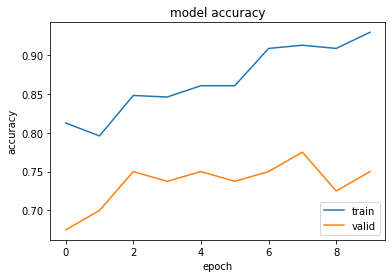

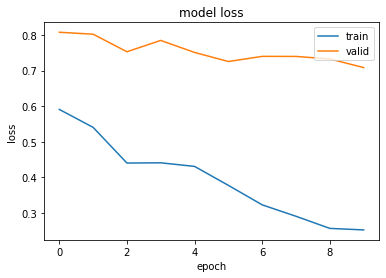

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [53]:
validation_generator_no_shuffle = validation_datagen.flow_from_directory(
        './validation',
        target_size=(image_size, image_size),
        batch_size=num_valid_images,
        classes=class_names,
        shuffle=False)


prediction = model_fine_tuned.predict_generator(validation_generator_no_shuffle,1)

Found 80 images belonging to 8 classes.


In [54]:
Y_valid = np.zeros((num_valid_images,1),dtype=int)

step = num_valid_images // num_classes
for ind in range(num_classes):
    Y_valid[ind*step:(ind+1)*step] = ind
    
confmat = confusion_matrix(Y_valid,np.argmax(prediction,axis=1))   

for i0 in range(num_classes):
    sys.stdout.write('[')
    for i1 in range(num_classes):
        sys.stdout.write('{:3d} '.format(confmat[i0,i1]))
    
    sys.stdout.write('], {}\n'.format(class_names[i0]))
    
sys.stdout.flush()

[  8   1   0   1   0   0   0   0 ], brad pitt
[  1   7   0   1   0   0   1   0 ], johnny deep
[  2   0   8   0   0   0   0   0 ], leonardo dicaprio
[  0   0   0   9   0   0   0   1 ], robert de niro
[  0   0   0   0   8   0   1   1 ], angelina jolie
[  0   0   0   0   1   7   0   2 ], sandra bullock
[  1   0   0   0   0   1   7   1 ], catherine deneuve
[  0   0   0   0   2   2   0   6 ], marion cotillard


wrong classification for: marion cotillard


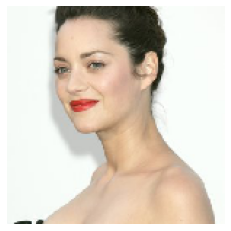

matched to: angelina jolie


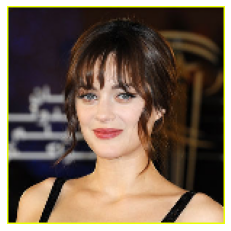

matched to: sandra bullock


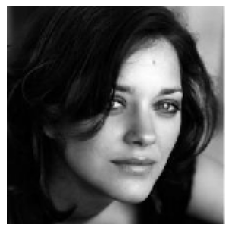

matched to: angelina jolie


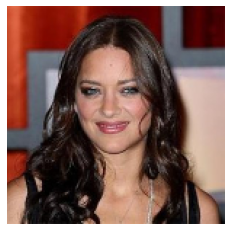

matched to: sandra bullock


In [55]:
# Choose the class label you want to check
clbl = 7
step = num_valid_images // num_classes
pred_labels = np.argmax(prediction[clbl*step:(clbl+1)*step],axis=1)
wrong_labels = np.transpose(np.nonzero(pred_labels != clbl))

print('wrong classification for: {}'.format(class_names[clbl]))
for i0 in wrong_labels:
    img = validation_generator_no_shuffle[0][0][clbl*step + i0,...]
    plot_img(img.reshape(150,150,3))
    print('matched to: {}'.format(class_names[pred_labels[i0][0]]))
    

## Tensorboard

In [56]:
!tensorboard --port=8061 --logdir=tensorboard/

2020-12-03 12:46:56.402694: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2020-12-03 12:46:56.402795: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2020-12-03 12:46:56.402812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.1 at http://localhost:8061/ (Press CTRL+C to quit)
^C


# Part III : Visualizing what ConvNets learn

We will introduce a visualization technique that is useful for understanding which parts of a given image led a ConvNet to its final classification decision. This is helpful for debugging the decision process of a ConvNet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.  

This general category of techniques is called a _class activation map_ (CAM) visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogs-versus-cats ConvNet, CAM visualization allows you to generate a heatmap for the class "cat", indicating how cat-like different parts of the image are, and also a heatmap for the class "dog", indicating how dog-like parts of the image are. 

The specific implementation we will use is the one described in _"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization."_ It's very simple: it consists of taking the output activations maps of a convolutional layer, given an input image, and weighing every activation map in that output volume by the gradient of the class with respect to the activation map. Intuitively, one way to understand this trick is that you are weighting a spatial map of "how intensely the input image activates different activation maps" by " how important each activation map is with regard to the class", resulting in a spatial map of "how intensely the input image activates the class."

We will demononstrate this technique using the pretrained VGG16 network again.


### Loading the VGG16 network with pretrained weights

Note that we include the densely connected classifier on top; in  
previous cases, we discarded it.

In [57]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 59s 0us/step


Consider the image of two African elephants shown below, possibly a mother and her calf, strolling on the savanna. Let us convert this image into something the VGG16 model can read: the model was trained on images of size 224x224, preprocessed according to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize it to 224x224, convert it to a Numpy `float32` tensor, and apply theses preprocessing rules.


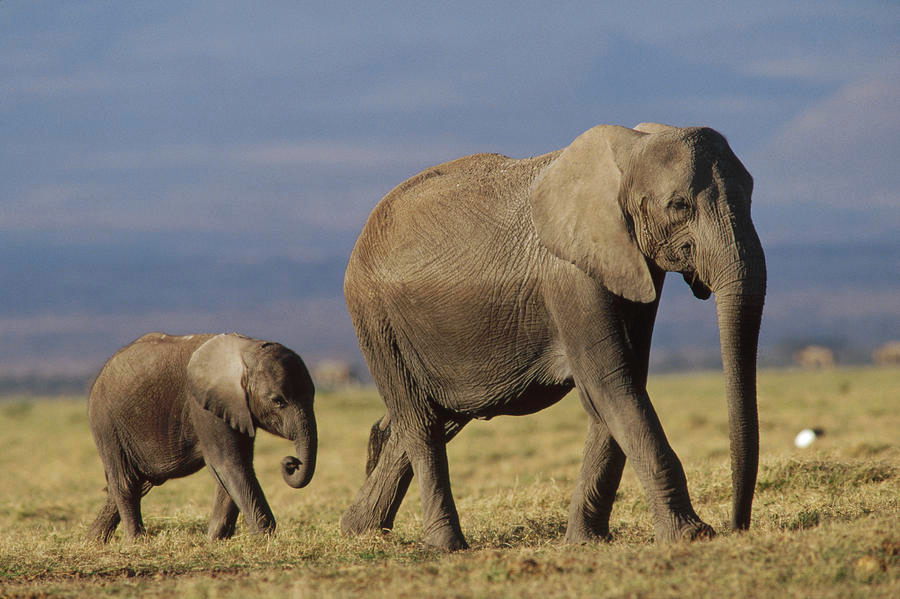

In [59]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np
import cv2 # if not installed, execute : !pip install opencv-python
# Local path to the target image
img_path = './african-elephant.jpg'
image_orig = cv2.imread(img_path)
print(image_orig.shape)

# Python Imaging Library (PIL) image of size 224x224
img = image.load_img(img_path, target_size=(224,224))

# float32 Numpy array of shape (224,224,3)
x = image.img_to_array(img)

# Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)
print(x.shape)

# Preprocess the batch (this does activation-map-wise color normalization)
x = preprocess_input(x)

(599, 900, 3)
(1, 224, 224, 3)


We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [60]:
preds = model.predict(x)
print('Predicted', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted [('n02504458', 'African_elephant', 0.54743534), ('n01871265', 'tusker', 0.2297366), ('n02504013', 'Indian_elephant', 0.18316984)]


The top three classes predicted for this image are as follows:

- African elephant (with 55% probability)
- Tusker (with 23% probability)
- Indian elephant (with  18% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the 
prediction vector that was maximally activated is the one corresponding to the "African elephant" class, index 386:

In [11]:
np.argmax(preds[0])

386

To visualize which parts of the image are the most African elephant-like, let's set up the Grad-CAM process. 

### Setting up the Grad-CAM algorithm

In [12]:
# import the necessary packages

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
import numpy as np
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)


# initialize the model to be VGG16
Model = VGG16

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = Model(weights="imagenet")



# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
# !pip install opencv-python-headless
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")  

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) 
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        #(w, h) = (image.shape[2], image.shape[1])
        heatmap = cam.numpy()
        #heatmap = cv2.resize(cam_num, (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

 

index_true_class = np.argmax(preds[0])
print(index_true_class)
cam = GradCAM(model, index_true_class)
heatmap = cam.compute_heatmap(x)
print(heatmap.shape)

[INFO] loading model...
386
(7, 7)


The result is shown below:

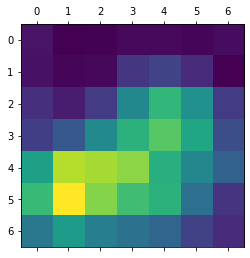

In [13]:
plt.matshow(heatmap)

### Superimposing the heatmap with the original picture

Finally, we will use OpenCV to generate an image that superimposes the original image on the heatmap we just obtained.

In [14]:
import cv2

# uses cv2 to load the original image
img = cv2.imread(img_path) 

# resizes the heatmap to be the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# applies the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# saves the image to disk
cv2.imwrite('./elephant_cam.jpg', superimposed_img)

True

![title](./elephant_cam.jpg)

The visualization technique answers two important questions:

- Why did the network think this image contained an African elephant?

- Where is the African elephant located in the picture?

In particular, it's interesting to note that the elephant calf is strongly activated.

# Part IV : Object Detection with Mask R-CNN

### Please run this section on Colab !

Object detection is a task in computer vision that involves identifying the presence, location, and type of one or more objects in a given photograph.

It is a challenging problem that involves building upon methods for object recognition (e.g. where are they), object localization (e.g. what are their extent), and object classification (e.g. what are they).

In recent years, deep learning techniques have achieved state-of-the-art results for object detection, such as on standard benchmark datasets and in computer vision competitions. Most notably is the R-CNN, or Region-Based Convolutional Neural Networks, and the most recent technique called Mask R-CNN that is capable of achieving state-of-the-art results on a range of object detection tasks.

In this section, we will discover how to use the __Mask R-CNN__ model to detect objects in new photographs.

After completing this tutorial, you will know:

- The region-based Convolutional Neural Network family of models for object detection and the most recent variation called Mask R-CNN.

- The best-of-breed open source library implementation of the Mask R-CNN for the Keras deep learning library.
    
- How to use a pre-trained Mask R-CNN to perform object localization and detection on new photographs.



## Mask R-CNN for Object Detection

Object detection is a computer vision task that involves both localizing one or more objects within an image and classifying each object in the image.

It is a challenging computer vision task that requires both successful object localization in order to locate and draw a bounding box around each object in an image, and object classification to predict the correct class of object that was localized.

An extension of object detection involves marking the specific pixels in the image that belong to each detected object instead of using coarse bounding boxes during object localization. This harder version of the problem is generally referred to as object segmentation or semantic segmentation.

The __Region-Based__ Convolutional Neural Network, or R-CNN, is a family of convolutional neural network models designed for object detection, developed by Ross Girshick, et al.

There are perhaps four main variations of the approach, resulting in the current pinnacle called Mask R-CNN. The salient aspects of each variation can be summarized as follows:

- __R-CNN__: Bounding boxes are proposed by the “selective search” algorithm, each of which is stretched and features are extracted via a deep convolutional neural network, such as AlexNet, before a final set of object classifications are made with linear SVMs.

- __Fast R-CNN__: Simplified design with a single model, bounding boxes are still specified as input, but a region-of-interest pooling layer is used after the deep CNN to consolidate regions and the model predicts both class labels and regions of interest directly.
    
- __Faster R-CNN__: Addition of a Region Proposal Network that interprets features extracted from the deep CNN and learns to propose regions-of-interest directly.
    
- __Mask R-CNN__: Extension of Faster R-CNN that adds an output model for predicting a mask for each detected object.

The Mask R-CNN model introduced in the 2018 paper titled [Mask R-CNN](https://arxiv.org/abs/1703.06870) is the most recent variation of the family models and supports both object detection and object segmentation. The paper provides a nice summary of the model linage to that point:



### Matterport Mask R-CNN Project

Mask R-CNN is a sophisticated model to implement, especially as compared to a simple or even state-of-the-art deep convolutional neural network model.

Source code is available for each version of the R-CNN model, provided in separate GitHub repositories with prototype models based on the Caffe deep learning framework. For example:

- R-CNN: [Regions with Convolutional Neural Network Features, GitHub](https://github.com/rbgirshick/rcnn)

- Fast R-CNN, [GitHub](https://github.com/rbgirshick/fast-rcnn)

- Faster R-CNN Python Code, [GitHub](https://github.com/rbgirshick/py-faster-rcnn)

- Detectron, Facebook AI, [GitHub](https://github.com/facebookresearch/Detectron)

Instead of developing an implementation of the R-CNN or Mask R-CNN model from scratch, we can use a reliable third-party implementation built on top of the Keras deep learning framework.

The best of breed third-party implementations of Mask R-CNN is the [Mask R-CNN](https://github.com/matterport/Mask_RCNN) Project developed by Matterport. The project is open source released under a permissive license (i.e. MIT license) and the code has been widely used on a variety of projects and Kaggle competitions.

Nevertheless, it is an open source project, subject to the whims of the project developers. As such, I have a fork of the project available, just in case there are major changes to the API in the future.

The project is light on API documentation, although it does provide a number of examples in the form of Python Notebooks that you can use to understand how to use the library by example. Two notebooks that may be helpful to review are:

- Mask R-CNN Demo, [Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb)

- Mask R-CNN – Inspect Trained Model, [Notebook](https://github.com/matterport/Mask_RCNN/blob/master/samples/coco/inspect_model.ipynb)

There are perhaps three main use cases for using the Mask R-CNN model with the Matterport library; they are:

- __Object Detection Application__: Use a pre-trained model for object detection on new images.

- __New Model via Transfer Learning__: Use a pre-trained model as a starting point in developing a model for a new object detection dataset.
    
- __New Model from Scratch__: Develop a new model from scratch for an object detection dataset.

In order to get familiar with the model and the library, we will look at the first example in the next section.

#### Object Detection With Mask R-CNN

In this section, we will use the Matterport Mask R-CNN library to perform object detection on arbitrary photographs.

Much like using a pre-trained deep CNN for image classification, e.g. such as VGG-16 trained on an ImageNet dataset, we can use a pre-trained Mask R-CNN model to detect objects in new photographs. In this case, we will use a Mask R-CNN trained on the [MS COCO object detection problem](http://cocodataset.org/#home).

#### Mask R-CNN Installation

The first step is to install the library.

At the time of writing, there is no distributed version of the library, so we have to install it manually. The good news is that this is very easy.

Installation involves cloning the GitHub repository and running the installation script on your workstation. If you are having trouble, see the [installation instructions](https://github.com/matterport/Mask_RCNN#installation) buried in the library’s readme file.

#### Step 0. Open Colab and Upload this Notebook

#### Step 1. Clone the Mask R-CNN GitHub Repository

This is as simple as running the following command from your command line:

In [16]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 30.52 MiB/s, done.
Resolving deltas: 100% (570/570), done.


This will create a new local directory with the name Mask_RCNN that looks as follows:

Mask_RCNN
├── assets
├── build
│   ├── bdist.macosx-10.13-x86_64
│   └── lib
│       └── mrcnn
├── dist
├── images
├── mask_rcnn.egg-info
├── mrcnn
└── samples
    ├── balloon
    ├── coco
    ├── nucleus
    └── shapes

#### Step 2. Install the Mask R-CNN Library

The library can be installed directly via pip.

Change directory into the _Mask_RCNN_ directory and run the installation script.

From the command line, type the following:

In [17]:
import os
os.chdir('./Mask_RCNN')
!pip3 install -r requirements.txt
!python3 setup.py install 

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/m

The library will then install directly and you will see a lot of successful installation messages ending with the following:

...
Finished processing dependencies for mask-rcnn==2.1

#### Step 3: Confirm the Library Was Installed

It is always a good idea to confirm that the library was installed correctly.

You can confirm that the library was installed correctly by querying it via the pip command; for example:

In [18]:
!pip3 show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


### Example of Object Localization

We are going to use a pre-trained Mask R-CNN model to detect objects on a new photograph.

#### Step 1. Download Model Weights

First, download the weights for the pre-trained model, specifically a Mask R-CNN trained on the MS Coco dataset.

The weights are available from the project GitHub project and the file is about 250 megabytes. Download the model weights to a file with the name ‘mask_rcnn_coco.h5‘ in your current working directory.

[Download Weights (mask_rcnn_coco.h5)](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5) (246 megabytes)

#### Step 2. Download Sample Photograph

We also need a photograph in which to detect objects.

Download from Ilias the photograph to your current working directory with the filename ‘african-elephant.jpg‘


african-elephant.jpg![grafik.png](attachment:grafik.png)

#### Step 3. Load Model and Make Prediction

First, the model must be defined via an instance MaskRCNN class.

This class requires a configuration object as a parameter. The configuration object defines how the model might be used during training or inference.

In this case, the configuration will only specify the number of images per batch, which will be one, and the number of classes to predict.

You can see the full extent of the configuration object and the properties that you can override in the [config.py](https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/config.py) file.

In [ ]:
%tensorflow_version 1.x
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80

We can now define the MaskRCNN instance.

We will define the model as type “inference” indicating that we are interested in making predictions and not training. We must also specify a directory where any log messages could be written, which in this case will be the current working directory.

In [ ]:
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())

The next step is to load the weights that we downloaded. You should save it on google drive and then load it.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# load coco model weights
rcnn.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True)

Now we can make a prediction for our image. First, we can load the image and convert it to a NumPy array.

In [ ]:
from tensorflow.keras.preprocessing import image
# load photograph
img = image.load_img('/content/drive/My Drive/african-elephant.jpg')
img = image.img_to_array(img)

We can then make a prediction with the model. Instead of calling `predict()` as we would on a normal Keras model, will call the `detect()` function and pass it the single image.

In [ ]:
# make prediction
results = rcnn.detect([img], verbose=0)

The result contains a dictionary for each image that we passed into the `detect()` function, in this case, a list of a single dictionary for the one image.

The dictionary has keys for the bounding boxes, masks, and so on, and each key points to a list for multiple possible objects detected in the image.

The keys of the dictionary of note are as follows:

- __‘rois‘__: The bound boxes or regions-of-interest (ROI) for detected objects.
- __‘masks‘__: The masks for the detected objects.
- __‘class_ids‘__: The class integers for the detected objects.
- __‘scores‘__: The probability or confidence for each predicted class.

We can draw each box detected in the image by first getting the dictionary for the first image (e.g. results[0]), and then retrieving the list of bounding boxes (e.g. [‘rois’]).

In [ ]:
boxes = results[0]['rois']

Each bounding box is defined in terms of the bottom left and top right coordinates of the bounding box in the image

In [ ]:
y1, x1, y2, x2 = boxes[0]

We can use these coordinates to create a `Rectangle()` from the matplotlib API and draw each rectangle over the top of our image.

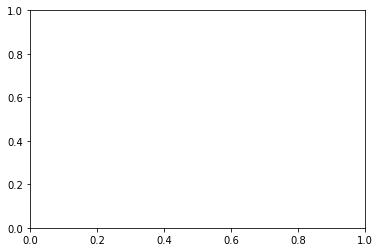

In [44]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.patches import Rectangle
ax = pyplot.gca()
# get coordinates
y1, x1, y2, x2 = boxes[0]
# calculate width and height of the box
width, height = x2 - x1, y2 - y1
# create the shape
rect = Rectangle((x1, y1), width, height, fill=False, color='red')
# draw the box
ax.add_patch(rect)

To keep things neat, we can create a function to do this that will take the filename of the photograph and the list of bounding boxes to draw and will show the photo with the boxes.

In [ ]:
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()

We can now tie all of this together and load the pre-trained model and use it to detect objects in our photograph of an elephant, then draw the photograph with all detected objects.

The complete example is listed below.

In [15]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80
 
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/content/drive/My Drive/mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('/content/drive/My Drive/african-elephant.jpg')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/content/drive/My Drive/african-elephant.jpg', results[0]['rois'])


ModuleNotFoundError: No module named 'keras'

Running the example loads the model and performs object detection. More accurately, we have performed object localization, only drawing bounding boxes around detected objects.

In this case, we can see that the model has correctly located the single object in the photo, the elephant, and drawn a red box around it.

## Example of Object Detection

Now that we know how to load the model and use it to make a prediction, let’s update the example to perform real object detection.

That is, in addition to localizing objects, we want to know what they are.

The `Mask_RCNN API` provides a function called `display_instances()` that will take the array of pixel values for the loaded image and the aspects of the prediction dictionary, such as the bounding boxes, scores, and class labels, and will plot the photo with all of these annotations.

One of the arguments is the list of predicted class identifiers available in the `class_id` key of the dictionary. The function also needs a mapping of ids to class labels. The pre-trained model was fit with a dataset that had 80 (81 including background) class labels, helpfully provided as a list in the [Mask R-CNN Demo, Notebook Tutorial](https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb), listed below.

In [ ]:
# define 81 classes that the coco model knowns about
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

We can then provide the details of the prediction for the elephant photo to the display_instances() function; for example:

In [16]:
from mrcnn.visualize import display_instances
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

ModuleNotFoundError: No module named 'mrcnn'

The `display_instances()` function is flexible, allowing you to only draw the mask or only the bounding boxes. You can learn more about this function in the `visualize.py` source file.

The complete example with this change using the `display_instances()` function is listed below.

Running the example shows the photograph of the two elephants with the annotations predicted by the Mask R-CNN model, specifically:

- __Bounding Box__: Dotted bounding box around each detected object.
- __Class Label__: Class label assigned each detected object written in the top left corner of the bounding box.
- __Prediction Confidence__: Confidence of class label prediction for each detected object written in the top left corner of the bounding box.
- __Object Mask Outline__: Polygon outline for the mask of each detected object.
- __Object Mask__: Polygon fill for the mask of each detected object.

The result is very impressive and sparks many ideas for how such a powerful pre-trained model could be used in practice.

# Suggestions for Your Project in DLV

1. Get familiar with different ConvNet architectures such as _EfficientNets_, _MobileNet_, etc. and apply transfer learning to your own dataset. Discuss the resulting confusion matrices and record test set accuracies, F1-scores, etc.

2. Scrape your own image dataset and label objects in your images by means of e.g. [labelImg](https://github.com/tzutalin/labelImg). Use [YOLO](https://github.com/Ma-Dan/keras-yolo4) and [SSD](https://github.com/pierluigiferrari/ssd_keras) to detect objects in your dataset. Compare your results with respect to speed and Intersection of Union (IoU) or Mean Average Precision (MAP) (see lecture notes).

3. Get acquainted with the [Coconut Annotator](https://github.com/jsbroks/coco-annotator) to annotate and segment objects in your images. Use Transfer Learning for object detection and classification. See [Mask RCNN for Object Detection and Segmentation](https://github.com/matterport/Mask_RCNN)

4. Discover which parts of an image are relevant for image classification. Apply GradCam and get familiar with [Layer-Wise Relevance Propagation](https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea). Use LRP with Keras (https://pypi.org/project/keras-explain/) to your image classification task.

5. Label joints of animals in your images by means of [DeepLabCut](http://www.mackenziemathislab.org/deeplabcut). Classify animals or poses of animals by means of (relative) joint coordinates. See as well [Real Time Pose Estimation](https://github.com/michalfaber/keras_Realtime_Multi-Person_Pose_Estimation)